## **Import Libraries**

#### **Paper:** https://arxiv.org/pdf/2401.15884

In [1]:
import time, re
from typing import List, TypedDict
from pydantic import BaseModel

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Markdown, Image

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

### **Load Books**

In [2]:
docs = (
    PyPDFLoader("../../../assets/books/deep_learning.pdf").load() +
    PyPDFLoader("../../../assets/books/hands_on_ml.pdf").load() +
    PyPDFLoader("../../../assets/books/pattern_recognition.pdf").load()
)

- docs length

In [3]:
len(docs)

2123

### **Split Documents into Chunks**

In [4]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

### **Embedding and Indexing**

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)

- **Retriever**

In [6]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [7]:
retrieved_docs = retriever.invoke("Explain the bias–variance tradeoff")

In [8]:
len(retrieved_docs)

4

- **LLM**

In [9]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [10]:
class State(TypedDict):
    question: str
    docs: List[Document]

    good_docs: List[Document]
    verdict: str
    reason: str
    
    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    answer: str

In [11]:
def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

- **Evaluator**

In [12]:
class DocEvalScore(BaseModel):
    score: float
    reason: str

In [58]:
doc_eval_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a strict retrieval evaluator for RAG.\n"
        "You will be given ONE retrieved chunk and a question.\n"
        "Return a relevance score in [0.0, 1.0].\n"
        "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
        "- 0.0: chunk is irrelevant\n"
        "Be conservative with high scores.\n"
        "Also return a short reason.\n"
        "Output JSON only."
    ),
    (
    "human", "Question: {question}\n\nSentence:\n{chunk}"
    )
])

In [59]:
doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)

In [60]:
LOWER_TH = 0.5
UPPER_TH = 0.7

In [61]:
def eval_doc(state: State) -> State:

    q = state["question"]
    
    scores: List[float] = []
    reasons: List[str] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        # 5) for CORRECT case we will refine only docs with score > LOWER_TH
        if out.score > LOWER_TH:
            good.append(d)

    # 2) CORRECT if at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # 3) INCORRECT if all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient."
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }

    # 4) Anything in between => AMBIGUOUS
    why = "Mixed relevance signals."
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}. {why}",
    }

In [62]:
evaluations = eval_doc({
    "question": "Explain the bias–variance tradeoff",
    "docs": retrieved_docs
})

In [63]:
len(evaluations['good_docs'])

4

In [65]:
evaluations['verdict']

'CORRECT'

- **Sentence-level DECOMPOSER**

In [66]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

In [67]:
context = "\n\n".join(d.page_content for d in retrieved_docs).strip()
# context

In [68]:
decomposed_context = decompose_to_sentences(context)
len(decomposed_context)

26

**FILTER (LLM judge)**

In [69]:
class KeepDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a strict relevance filter.\n"
        "Return keep=true only if the sentence directly helps answer the question.\n"
        "Use ONLY the sentence. Output JSON only.",
    ),
    (
    "human", "Question: {question}\n\nSentence:\n{sentence}"
    )
])

In [70]:
filter_chain = filter_prompt | llm.with_structured_output(KeepDrop)

- **REFINING (Decompose -> Filter -> Recompose)**

In [71]:
def refine(state: State) -> State:

    q = state["question"]

    # Combine retrieved docs into one context string
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()

    # 1) DECOMPOSITION: context -> sentence strips
    strips = decompose_to_sentences(context)

    # 2) FILTER: keep only relevant strips
    kept: List[str] = []
    
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    # 3) RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [72]:
refined = refine({"question": "Explain the bias–variance tradeoff", "docs": retrieved_docs})

In [76]:
# refined['refined_context']

- **ANSWER GENERATION**

In [77]:
answer_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a helpful ML tutor. Answer ONLY using the provided refined bullets.\n"
        "If the bullets are empty or insufficient, say: 'I don't know based on the provided books.'",
    ),
    (
    "human", "Question: {question}\n\nRefined context:\n{refined_context}"
    ),
])

In [78]:
def generate_answer(state: State) -> State:
    output = (answer_prompt | llm).invoke({
        "question": state["question"], 
        "refined_context": state["refined_context"]
    })

    return {"answer": output.content}

- **FAIL/AMBIGUOUS NODES**

In [79]:
def fail_node(state: State) -> State:
    return { "answer": f"FAIL: {state['reason']}" }

def ambiguous_node(state: State) -> State:
    return { "answer": f"AMBIGUOUS: {state['reason']}" }

def route_node(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refiner"
    elif state["verdict"] == "INCORRECT":
        return "websearch"
    else:
        return "ambiguous"

- **GRAPH**

In [80]:
graph = StateGraph(State)

graph.add_node("retrieve", retrieve)
graph.add_node("eval_doc", eval_doc)
graph.add_node("refine", refine)
graph.add_node("generate_answer", generate_answer)
graph.add_node("fail", fail_node)
graph.add_node("ambiguous_node", ambiguous_node)

graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "eval_doc")

graph.add_conditional_edges(
    "eval_doc", route_node,
    { "refiner":"refine", "websearch": "fail", "ambiguous": "ambiguous_node" }
)

graph.add_edge("refine", "generate_answer")
graph.add_edge("ambiguous_node", END)
graph.add_edge("fail", END)

rag = graph.compile()

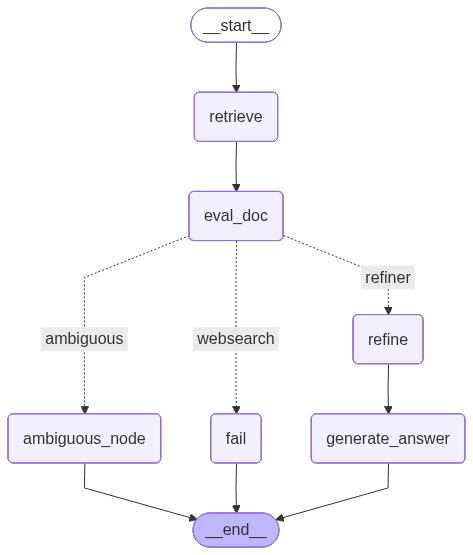

In [81]:
display(Image(rag.get_graph(xray=1).draw_mermaid_png()))

In [82]:
def run(question: str) -> dict:
    res = rag.invoke(
        {
            "question": question,
            "docs": [],
            "good_docs": [],
            "verdict": "",
            "reason": "",
            "strips": [],
            "kept_strips": [],
            "refined_context": "",
            "answer": "",
        }
    )
    return res

In [83]:
res = run("What are attention mechanisms and why are they important in current models?")

In [84]:
res.keys()

dict_keys(['question', 'docs', 'good_docs', 'verdict', 'reason', 'strips', 'kept_strips', 'refined_context', 'answer'])

In [85]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.

OUTPUT:
 I don't know based on the provided books.


In [86]:
res['refined_context']

''

In [87]:
display(Markdown(res["answer"]))

I don't know based on the provided books.

- Bias variance tradeoff
- AI news from last week
- What are attention mechanisms and why are they important in current models?

In [88]:
res = run("Explain the bias–variance tradeoff")

In [90]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
# print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.


In [91]:
display(Markdown(res["answer"]))

The bias–variance tradeoff is a fundamental concept in statistics and machine learning that describes the relationship between bias, variance, and the generalization error of a model. 

- Bias measures the expected deviation from the true value, often due to incorrect assumptions about the data (e.g., assuming linearity when the relationship is quadratic). High-bias models tend to underfit the training data.
- Variance measures the model's sensitivity to small variations in the training data. High-variance models can overfit the training data.
- The generalization error can be expressed as the sum of bias, variance, and a constant noise term.
- There is a trade-off: flexible models have low bias and high variance, while rigid models have high bias and low variance.
- The goal is to find a model that achieves the best balance between bias and variance to minimize expected loss.
- Increasing model complexity typically increases variance and reduces bias, while reducing complexity increases bias and decreases variance.